### Alpha-Line Interpolation Between Robust/Feeble Model

##### Summary
Load model trained with federated adversarial training (FAT, high robustness against adversarial attacks) and FedAvg (low robustness). We make linear combinations of parameters of models and see if the robustness gradually changes as we sweep between FAT and FedAvg models.

Figure 4c

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

torch.cuda.empty_cache()


/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
setting, num_user = "FedAvg_adv", 40
dataset = 'celeba'
eps = 4

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = dataset) # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FedAvg/'

# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 95%|█████████▌| 19/20 [00:01<00:00, 15.22it/s]


===> Initializing clients..


100%|██████████| 20/20 [00:01<00:00, 18.83it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(tor

In [4]:
# Linear extrapolation of model for each layer
stepsize_alpha = 0.05
alpha_set = np.arange(0,1+stepsize_alpha,stepsize_alpha)

models_test = []

params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()


for (a) in alpha_set:
    # first make the model with empty weights
    new_model = copy.deepcopy(model_FAT)
    new_model.eval()
    new_weight_dict = copy.deepcopy(params_FAT)
    for key in params_FAT:
        new_weight_dict[key] = a*params_FedAvg[key] + (1-a)*params_FAT[key] 
    new_model.load_state_dict(new_weight_dict)
    models_test += [new_model]


In [5]:
# Perform transfer attack from one client to another and record stats
# models_test = [model_Fedavg, model_FAT]

alpha_list = alpha_set.tolist()
num_trials = 5
acc_store_agg = np.zeros([num_trials, len(alpha_list)])
adv_store_agg = np.zeros([num_trials, len(alpha_list)])

for itt in range(num_trials):

    # Run Measurements for both targetted and untargeted analysis
    victim_idxs = range(len(models_test))
    logs_adv = generate_logs_adv(len(models_test))
    custom_batch_size = 100


    dataloader = load_client_data(clients = clients, c_id = 0, mode = 'all') # or test/train
    cross_attack(logs_adv, victim_idxs, dataloader, models_test, custom_batch_size, eps)

    metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
                'adv_similarities_untarget','adv_target','adv_miss']

    adv_miss = get_metric_list("adv_miss", logs_adv, victim_idxs)
    acc = get_metric_list("orig_acc_transfers", logs_adv, victim_idxs)

    # Print along diagonal and plot "robustness against white-box attacks (self)"
    adv_list = []
    acc_list = []
    for i in range(adv_miss.shape[0]):
        adv_list += [adv_miss[i,i]]
        acc_list += [acc[i,i]]

    acc_store_agg[itt,:] = np.array(acc_list)
    adv_store_agg[itt,:] = np.array(adv_list)



	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Ad

In [6]:
acc_list_true = np.mean(acc_store_agg, axis = 0)
adv_list_true = np.mean(adv_store_agg, axis = 0)

acc_list_std = np.std(acc_store_agg, axis = 0)
adv_list_std = np.std(adv_store_agg, axis = 0)

print(acc_list_true)
print(acc_list_std)
print(adv_list_true)
print(adv_list_std)

[0.73 0.75 0.74 0.69 0.75 0.72 0.76 0.77 0.74 0.76 0.76 0.76 0.76 0.76
 0.78 0.77 0.82 0.78 0.80 0.80 0.78]
[0.03 0.03 0.03 0.04 0.07 0.04 0.05 0.02 0.05 0.04 0.01 0.06 0.03 0.04
 0.03 0.03 0.03 0.05 0.05 0.04 0.01]
[0.37 0.41 0.35 0.32 0.31 0.31 0.28 0.29 0.24 0.21 0.24 0.23 0.16 0.16
 0.15 0.13 0.12 0.09 0.08 0.04 0.04]
[0.04 0.06 0.04 0.01 0.03 0.03 0.03 0.03 0.02 0.05 0.03 0.03 0.03 0.04
 0.02 0.02 0.03 0.02 0.02 0.02 0.02]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


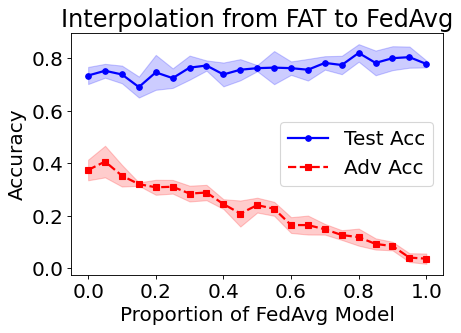

In [7]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Sample data
x = alpha_list
y1 = acc_list_true
y2 = adv_list_true

# Compute standard deviation
std1 = acc_list_std  # Replace with actual standard deviation values
std2 = adv_list_std  # Replace with actual standard deviation values

font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot the first line (y1) with shaded region for standard deviation
plt.plot(x, y1, label='Test Acc', color='b', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.fill_between(x, y1 - std1, y1 + std1, color='b', alpha=0.2)

# Plot the second line (y2) with shaded region for standard deviation
plt.plot(x, y2, label='Adv Acc', color='r', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.fill_between(x, y2 - std2, y2 + std2, color='r', alpha=0.2)

# Set plot title and labels
plt.title('Interpolation from FAT to FedAvg')
plt.xlabel('Proportion of FedAvg Model')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()
